In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sub_df = pd.read_csv("submit_sample.csv")

In [24]:
train_df.shape

(27532, 16)

In [25]:
test_df.shape

(27537, 15)

In [26]:
sub_df.shape

(27536, 2)

In [27]:
train_df.head(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158


In [28]:
train_df.tail(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price
27527,27527,williamsport,2008,ford,good,6 cylinders,gas,26660,clean,automatic,rwd,compact,truck,black,pa,32212
27528,27528,tulsa,2007,ford,excellent,8 cylinders,gas,108072,clean,automatic,rwd,full-size,pickup,black,NaN,5400
27529,27529,rochester,2019,jeep,like new,6 cylinders,gas,139908,clean,automatic,4wd,mid-size,SUV,white,ny,22227
27530,27530,rochester,2007,jeep,excellent,6 cylinders,gas,112326,clean,automatic,4wd,mid-size,sedan,white,ny,3054
27531,27531,orange county,2009,chevrolet,excellent,8 cylinders,gas,91813,rebuilt,automatic,rwd,full-size,van,white,ca,20801


In [29]:
test_df.head(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
0,27532,western slope,2015,chevrolet,excellent,4 cylinders,gas,92553,clean,automatic,fwd,full-size,SUV,red,NaN
1,27533,roseburg,2013,nissan,like new,4 cylinders,gas,134385,salvage,automatic,fwd,mid-size,sedan,black,or
2,27534,akron / canton,2011,volkswagen,good,4 cylinders,gas,102489,clean,automatic,fwd,full-size,sedan,black,oh
3,27535,denver,2016,jeep,excellent,6 cylinders,diesel,64310,clean,automatic,4wd,mid-size,SUV,red,co
4,27536,hickory / lenoir,1999,honda,excellent,8 cylinders,gas,180839,rebuilt,automatic,4wd,mid-size,SUV,silver,nc


In [30]:
test_df.tail(5)

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state
27532,55064,great falls,2016,gmc,excellent,6 cylinders,gas,90902,rebuilt,automatic,fwd,full-size,truck,black,mt
27533,55065,las vegas,2012,nissan,excellent,4 cylinders,gas,27234,rebuilt,automatic,fwd,mid-size,sedan,white,nv
27534,55066,phoenix,2002,bmw,excellent,6 cylinders,gas,99761,clean,automatic,rwd,full-size,coupe,blue,az
27535,55067,colorado springs,2006,bmw,excellent,6 cylinders,gas,162279,clean,automatic,4wd,mid-size,sedan,silver,co
27536,55068,syracuse,2006,jeep,excellent,6 cylinders,gas,186965,clean,automatic,4wd,full-size,SUV,black,ny


In [31]:
train_df["manufacturer"].unique()

array(['bmw', 'toyota', 'ford', 'nissan', 'volkswagen', 'FORD', 'lexus',
       'buick', 'subaru', 'ram', 'TOYOTA', 'dodge', 'ｂｍｗ', 'chevrolet',
       'RAM', 'BMW', 'jeep', 'ｃｈｅｖｒｏｌｅｔ', 'honda', 'NISSAN', 'hyundai',
       'chrysler', 'gmc', 'mazda', 'audi', 'lincoln', 'kia',
       'mercedes-benz', 'mitsubishi', 'CHEVROLET', 'GMC', 'ｆｏｒｄ', 'BUICK',
       'saturn', 'infiniti', 'MINI', 'mercury', 'cadillac',
       'MERCEDES-BENZ', 'pontiac', 'acura', 'HONDA', 'ACURA', 'KIA',
       'fiat', 'jaguar', 'ｒａｍ', 'mini', 'LEXUS', 'VOLKSWAGEN', 'ｋｉａ',
       'SUBARU', 'ｎｉｓｓａｎ', 'DODGE', 'volvo', 'HYUNDAI', 'MAZDA', 'ｈｏｎｄａ',
       'ｍａｚｄａ', 'INFINITI', 'CADILLAC', 'JEEP', 'LINCOLN', 'ｔｏｙｏｔａ',
       'niѕsan', 'AUDI', 'ＶＯＬＫＳＷＡＧＥＮ', 'ＣＨＥＶＲＯＬＥＴ', 'MERCURY', 'ｂｕｉｃｋ',
       'ROVER', 'ｄｏｄｇｅ', 'porsche', 'ｖｏｌｖｏ', 'ｖｏｌｋｓｗａｇｅｎ', 'JAGUAR',
       'SATURN', 'ｊｅｅｐ', 'rover', 'ｓｕｂａｒｕ', 'CHRYSLER', 'PONTIAC',
       'ｍｉｔｓｕｂｉｓｈｉ', 'ＴＯＹＯＴＡ', 'ＢＭＷ', 'ｃｈｒｙｓｌｅｒ', 'nisѕan', 'MITSUBISHI',
       'ｈｙｕｎｄａｉ', 'ｇｍｃ'

In [32]:
#メーカの表記ゆれを統一
import unicodedata
train_df['manufacturer'] = train_df['manufacturer'].str.upper()

# 全角英語を英語大文字に変換する関数
def convert_fullwidth_to_upper(text):
    return ''.join(unicodedata.normalize('NFKC', char).upper() for char in text)
# nameカラムの要素を英語大文字に統一します
train_df['manufacturer'] = train_df['manufacturer'].apply(convert_fullwidth_to_upper)

train_df["manufacturer"].replace("ᴄHRYSLER","CHEVROLET",inplace=True)
train_df["manufacturer"].replace("SUBΑRU","SUBARU",inplace=True)
train_df["manufacturer"].replace("TOYOTА","TOYOTA",inplace=True)
train_df["manufacturer"].replace("NIЅSAN","NISSAN",inplace=True)
train_df["manufacturer"].replace("NISЅAN","NISSAN",inplace=True)
train_df["manufacturer"].replace("SΑTURN","SATURN",inplace=True)
train_df["manufacturer"].replace("АCURA","ACURA",inplace=True)
train_df["manufacturer"].replace("VОLKSWAGEN","VOLKSWAGEN",inplace=True)
train_df["manufacturer"].replace("LEXUЅ","LEXUS",inplace=True)
# 結果を表示
print(train_df["manufacturer"].unique())



['BMW' 'TOYOTA' 'FORD' 'NISSAN' 'VOLKSWAGEN' 'LEXUS' 'BUICK' 'SUBARU'
 'RAM' 'DODGE' 'CHEVROLET' 'JEEP' 'HONDA' 'HYUNDAI' 'CHRYSLER' 'GMC'
 'MAZDA' 'AUDI' 'LINCOLN' 'KIA' 'MERCEDES-BENZ' 'MITSUBISHI' 'SATURN'
 'INFINITI' 'MINI' 'MERCURY' 'CADILLAC' 'PONTIAC' 'ACURA' 'FIAT' 'JAGUAR'
 'VOLVO' 'ROVER' 'PORSCHE' 'LAND ROVER' 'ASTON-MARTIN' 'ALFA-ROMEO']


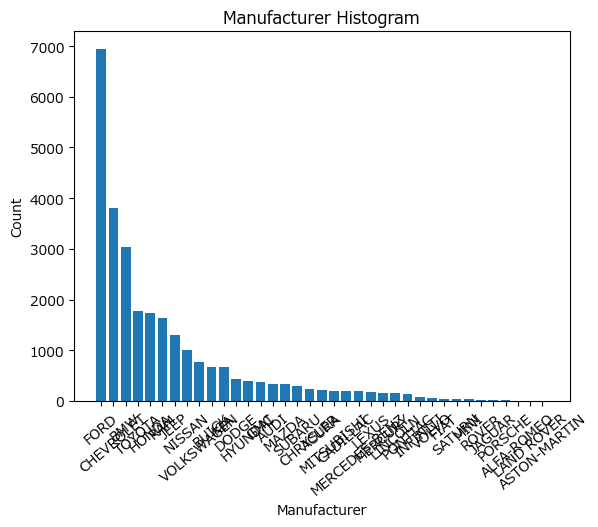

<Figure size 5000x600 with 0 Axes>

<Figure size 5000x600 with 0 Axes>

In [33]:
manufacturer_hist = train_df["manufacturer"].value_counts()

# ヒストグラムを描画
plt.bar(manufacturer_hist.index, manufacturer_hist.values)
plt.xlabel('Manufacturer')
plt.ylabel('Count')
plt.title('Manufacturer Histogram')
plt.xticks(rotation=40)
plt.show()
plt.figure(figsize=(50, 6))  

In [34]:
manufacturer_hist

FORD             6943
CHEVROLET        3808
BMW              3044
TOYOTA           1784
HONDA            1742
RAM              1639
JEEP             1297
NISSAN           1003
VOLKSWAGEN        773
BUICK             678
KIA               668
DODGE             433
HYUNDAI           391
GMC               370
AUDI              329
MAZDA             327
SUBARU            290
CHRYSLER          236
ACURA             224
MITSUBISHI        206
CADILLAC          204
MERCEDES-BENZ     199
LEXUS             187
MERCURY           155
LINCOLN           152
PONTIAC           145
INFINITI           73
VOLVO              60
FIAT               43
SATURN             42
MINI               37
ROVER              18
JAGUAR             12
PORSCHE            12
ALFA-ROMEO          4
LAND ROVER          2
ASTON-MARTIN        2
Name: manufacturer, dtype: int64

In [35]:
train_df["manufacturer"].unique()

array(['BMW', 'TOYOTA', 'FORD', 'NISSAN', 'VOLKSWAGEN', 'LEXUS', 'BUICK',
       'SUBARU', 'RAM', 'DODGE', 'CHEVROLET', 'JEEP', 'HONDA', 'HYUNDAI',
       'CHRYSLER', 'GMC', 'MAZDA', 'AUDI', 'LINCOLN', 'KIA',
       'MERCEDES-BENZ', 'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
       'MERCURY', 'CADILLAC', 'PONTIAC', 'ACURA', 'FIAT', 'JAGUAR',
       'VOLVO', 'ROVER', 'PORSCHE', 'LAND ROVER', 'ASTON-MARTIN',
       'ALFA-ROMEO'], dtype=object)

In [36]:
train_df["state"].unique()

array([nan, 'pa', 'ks', 'ny', 'ca', 'al', 'or', 'va', 'mt', 'nj', 'ma',
       'wi', 'sc', 'wa', 'dc', 'oh', 'in', 'de', 'fl', 'nm', 'az', 'ok',
       'mn', 'co', 'nv', 'wv', 'tn', 'mi', 'ri', 'il', 'tx', 'ut', 'ia',
       'ga', 'md', 'mo', 'ky', 'nc', 'ak', 'id', 'ct', 'wy', 'nd', 'me',
       'ar', 'hi', 'sd', 'ne', 'nh', 'vt', 'la', 'ms'], dtype=object)

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def des(X, train_df):
    # manufacturerがXの行のみを抽出します
    manufacturer_df = train_df[train_df['manufacturer'] == X]

    plt.rcParams['font.family'] = 'Meiryo'
    # ヒストグラムを作成して表示します
    bins = np.arange(0, 90001, 2500)  # 2500ごとの範囲を指定
    plt.hist(manufacturer_df['price'], bins=bins, edgecolor='black')

    # 各棒のパーセンテージを計算して表示
    total_samples = len(manufacturer_df)
    patches = plt.gca().patches
    for patch in patches:
        height = patch.get_height()
        percentage = (height / total_samples) * 100
        plt.annotate(f'{percentage:.1f}%', xy=(patch.get_x() + patch.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center')

    # 注釈を付ける条件とメッセージを定義
    conditions = [(0.5, 10000), (0.6, 10000), (0.7, 10000),
                  (0.5, 12500), (0.6, 12500), (0.7, 12500),
                  (0.2, 15000, 25000), (0.25, 15000, 25000), (0.3, 15000, 25000),
                  (0.05, 25000,40000), (0.1, 25000,40000), (0.15, 25000,40000)]

    matched_messages = []  # メッセージを保持するリスト
    for condition in conditions:
        if len(condition) == 3:
            percentage_threshold, price_min, price_max = condition
            count_threshold = total_samples * percentage_threshold
            count_within_range = np.sum((manufacturer_df['price'] >= price_min) & (manufacturer_df['price'] <= price_max))
            if count_within_range >= count_threshold:
                message = f'{int(percentage_threshold * 100)}%_{price_min}~{price_max}'
                matched_messages.append(message)
        else:
            percentage_threshold, price_threshold = condition
            count_threshold = total_samples * percentage_threshold
            count_below_threshold = np.sum(manufacturer_df['price'] <= price_threshold)
            if count_below_threshold >= count_threshold:
                message = f'{int(percentage_threshold * 100)}%_{price_threshold}'
                matched_messages.append(message)

    if matched_messages:
        print("該当するメッセージ:")
        for message in matched_messages:
            print(message)

    plt.xlabel('ドル')
    plt.ylabel('count')
    plt.title('値段と販売台数')
    plt.show()



該当するメッセージ:
50%_12500
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000


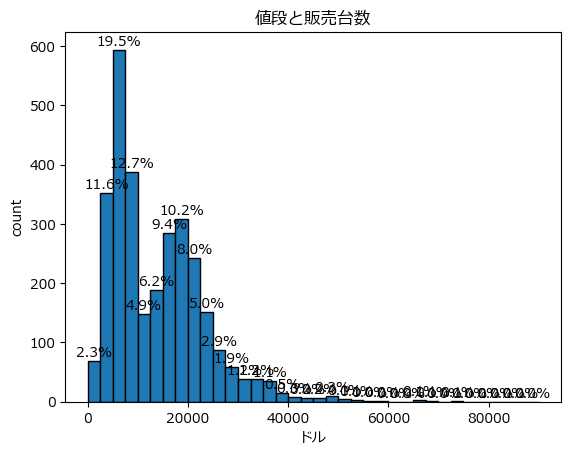

In [38]:
des("BMW",train_df)

In [39]:
manu_list=train_df["manufacturer"].unique()

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000
15%_25000~40000


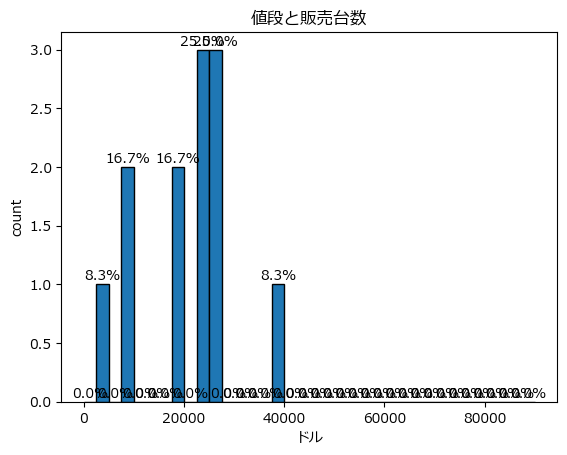

In [40]:
des("PORSCHE",train_df)

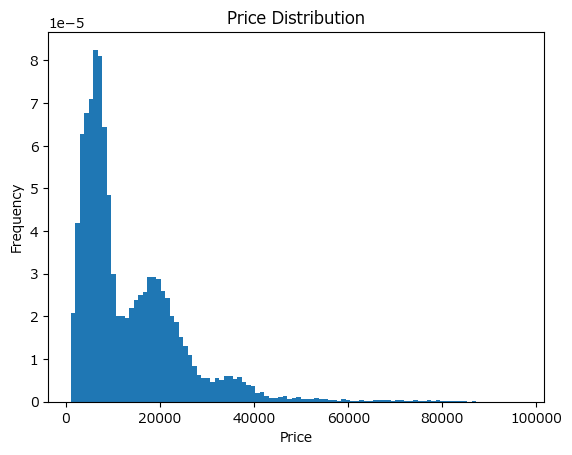

In [41]:
import matplotlib.pyplot as plt

price_data = train_df["price"]

# 1. ビンの数を指定してヒストグラムを表示
plt.hist(price_data, bins=100,density=True)

# 2. ヒストグラムを正規化して表示


# 3. 対数軸を使用して表示
# plt.hist(price_data, bins=20, log=True)

plt.xlabel("Price")
plt.ylabel("Frequency")
plt.title("Price Distribution")
plt.show()


該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


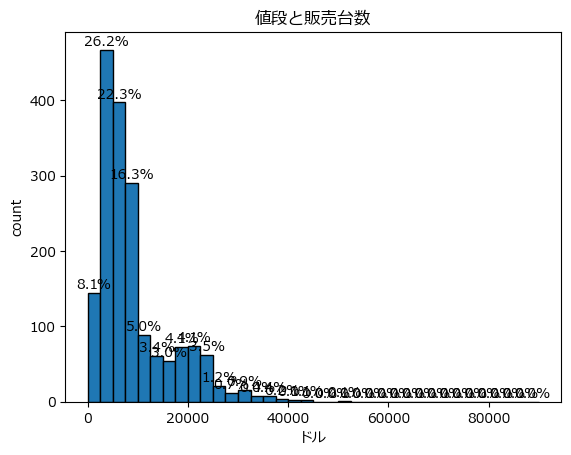

In [42]:
des("TOYOTA",train_df)

該当するメッセージ:
50%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000
10%_25000~40000


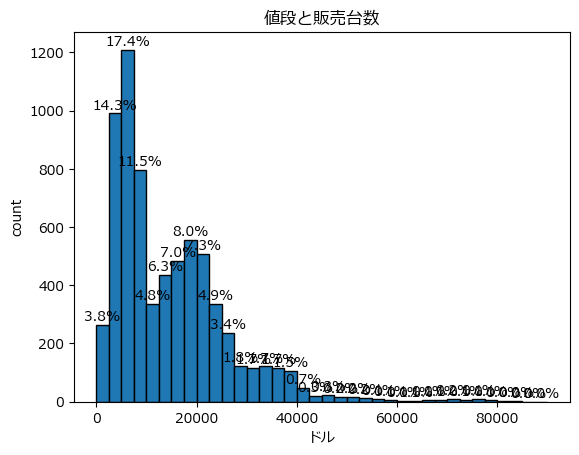

In [43]:
des("FORD",train_df)

該当するメッセージ:
50%_10000
60%_10000
50%_12500
60%_12500
70%_12500
5%_25000~40000


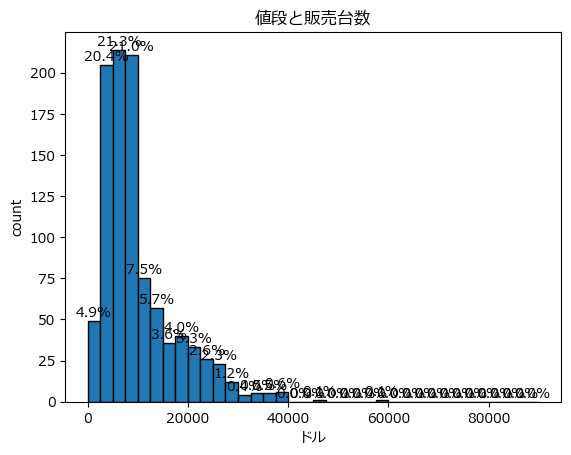

In [44]:
des('NISSAN',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


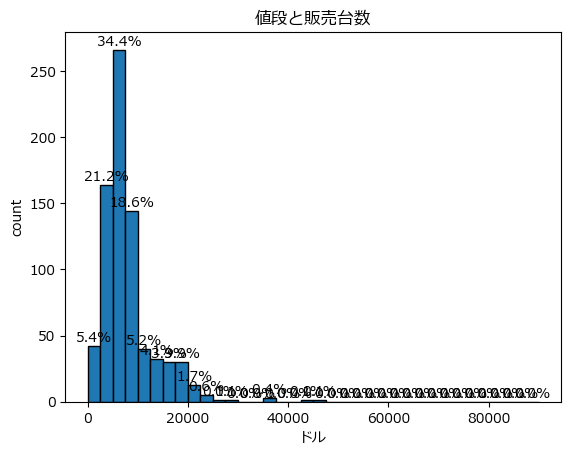

In [45]:
des('VOLKSWAGEN',train_df)

該当するメッセージ:
50%_10000
60%_10000
50%_12500
60%_12500
70%_12500
5%_25000~40000


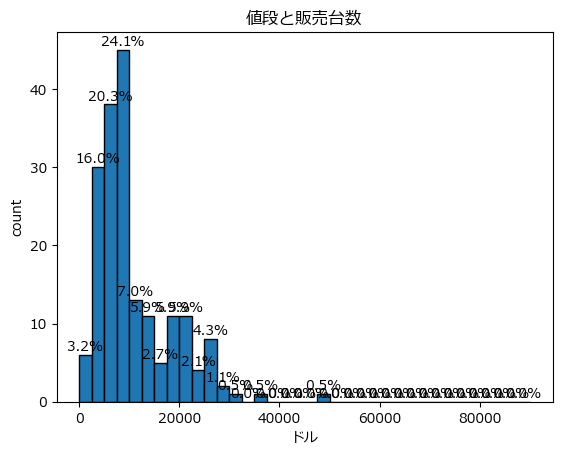

In [46]:
des('LEXUS',train_df)

該当するメッセージ:
50%_10000
60%_10000
50%_12500
60%_12500
5%_25000~40000


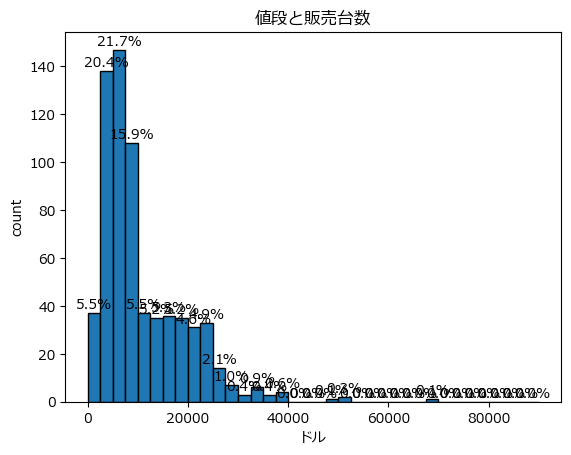

In [47]:
des('BUICK',train_df)

該当するメッセージ:
50%_10000
50%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000


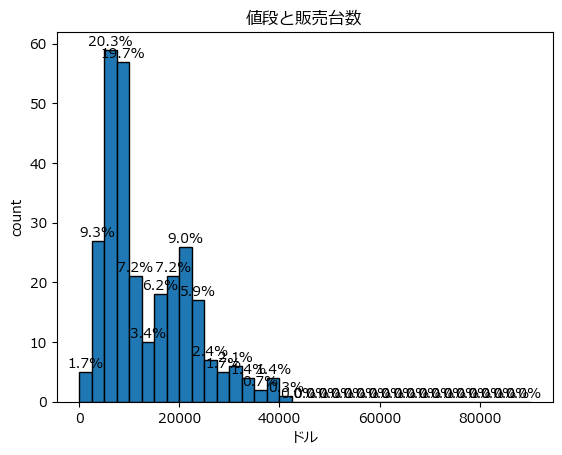

In [48]:
des("SUBARU",train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000
15%_25000~40000


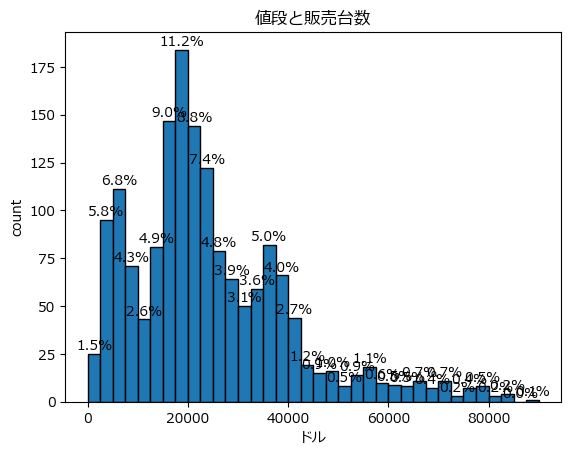

In [49]:
des('RAM',train_df)

該当するメッセージ:
50%_10000
50%_12500
20%_15000~25000
5%_25000~40000
10%_25000~40000


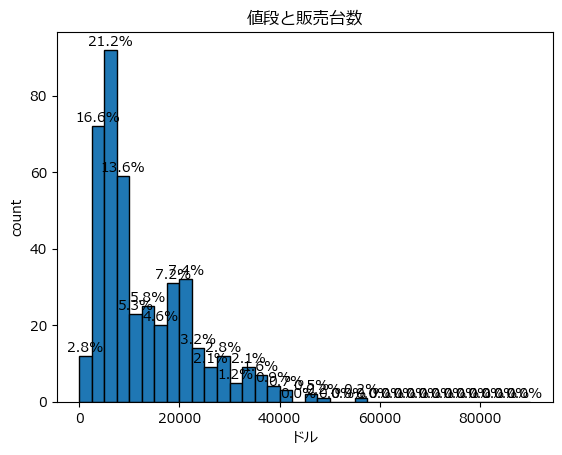

In [50]:
des( 'DODGE',train_df)

該当するメッセージ:
50%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000
10%_25000~40000


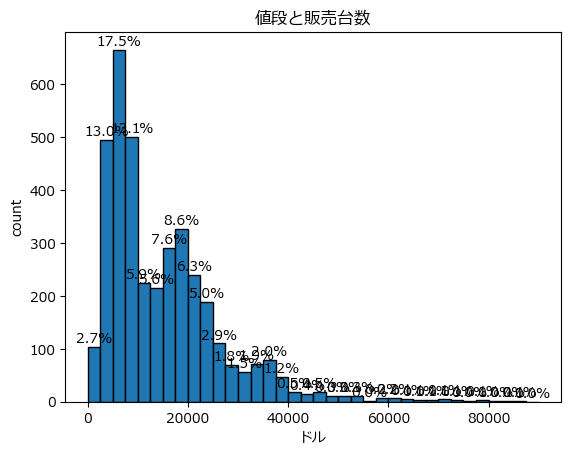

In [51]:
des('CHEVROLET',train_df)

該当するメッセージ:
50%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000
10%_25000~40000


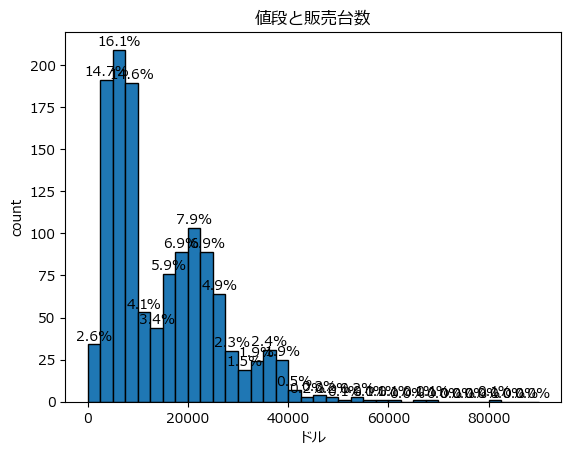

In [52]:
des('JEEP',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


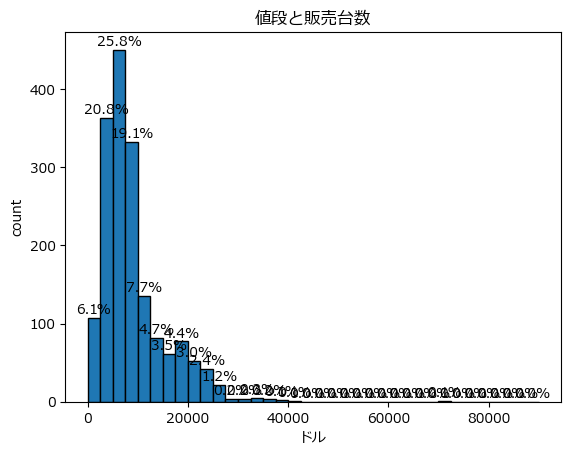

In [53]:
des('HONDA',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


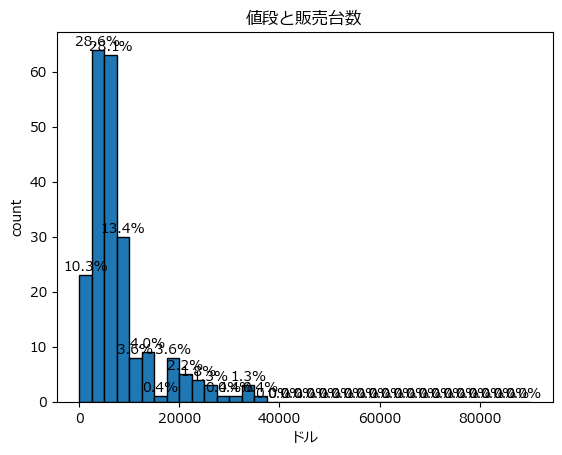

In [54]:
des("ACURA",train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


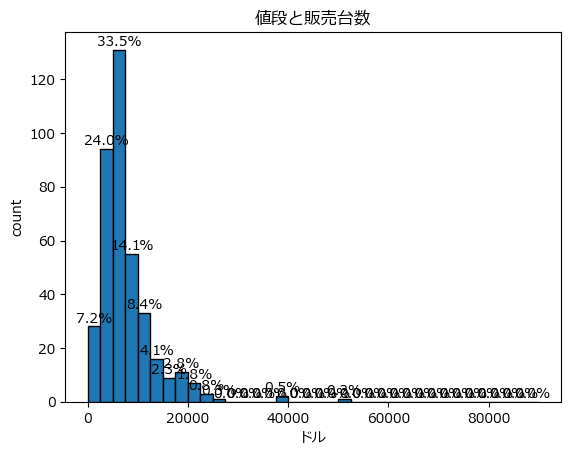

In [55]:
des('HYUNDAI',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


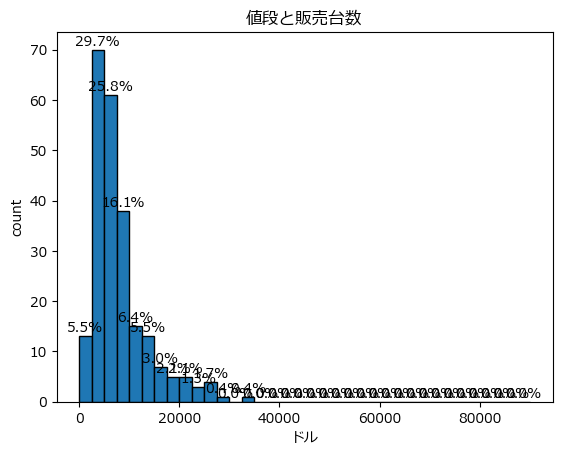

In [56]:
des('CHRYSLER',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000


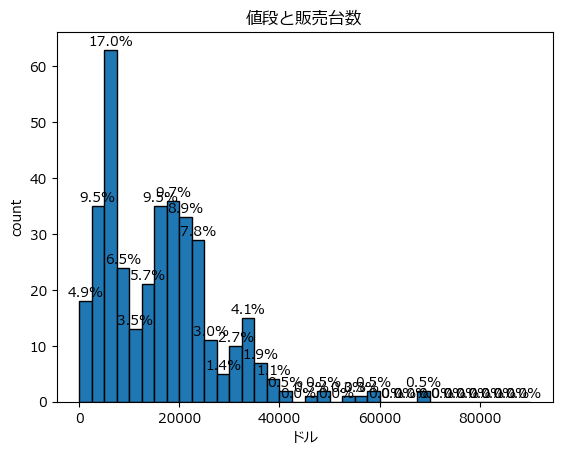

In [57]:
des("GMC",train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


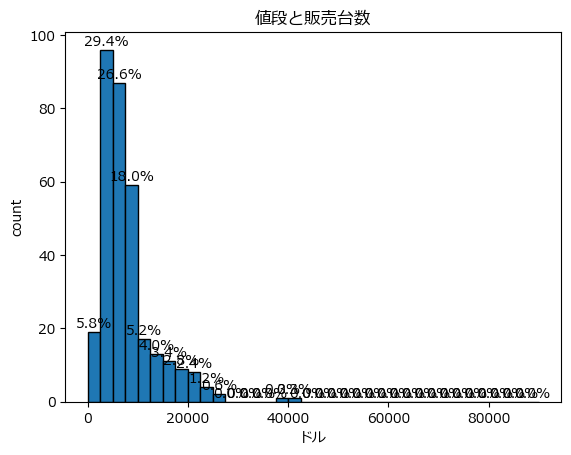

In [58]:
des('MAZDA',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000


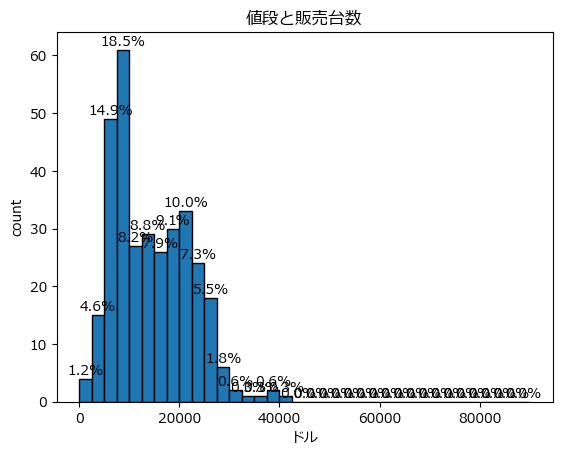

In [59]:
des('AUDI',train_df)

該当するメッセージ:
50%_10000
60%_10000
50%_12500
60%_12500
70%_12500


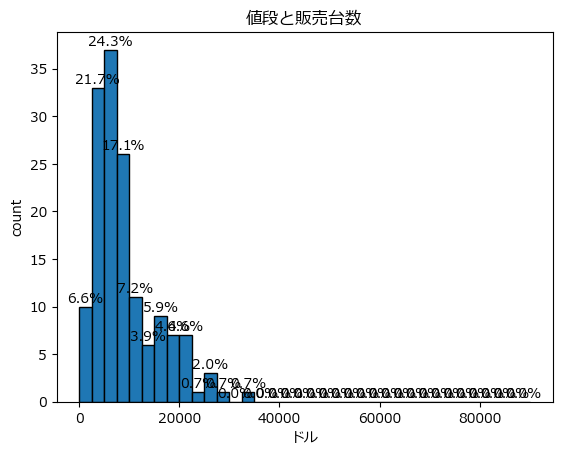

In [60]:
des('LINCOLN',train_df)

該当するメッセージ:
50%_10000
60%_10000
50%_12500
60%_12500
70%_12500


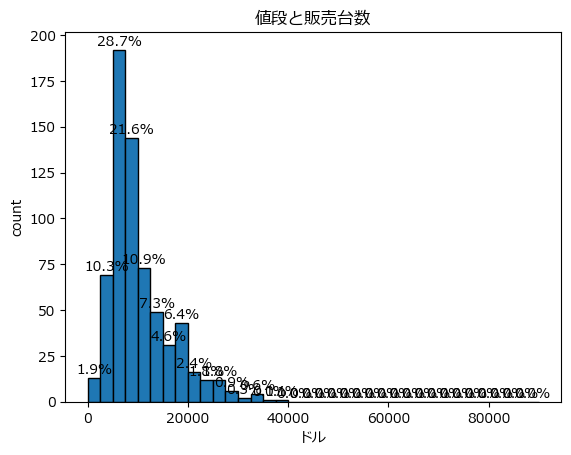

In [61]:
des('KIA',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000


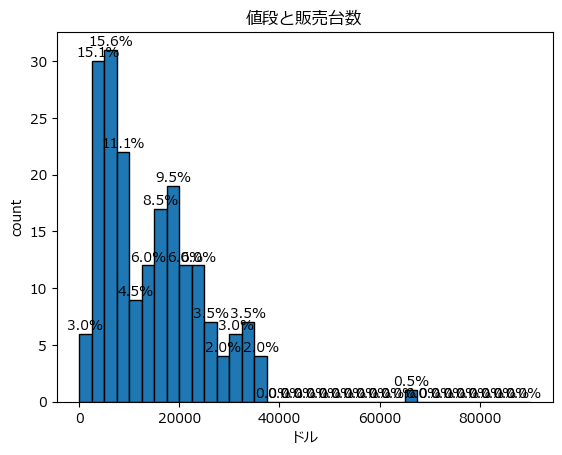

In [62]:
des('MERCEDES-BENZ',train_df)

該当するメッセージ:
50%_10000
50%_12500
60%_12500
20%_15000~25000
5%_25000~40000


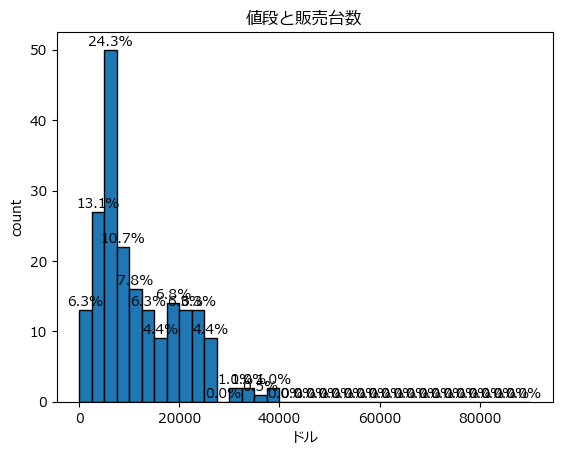

In [63]:
des('MITSUBISHI',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


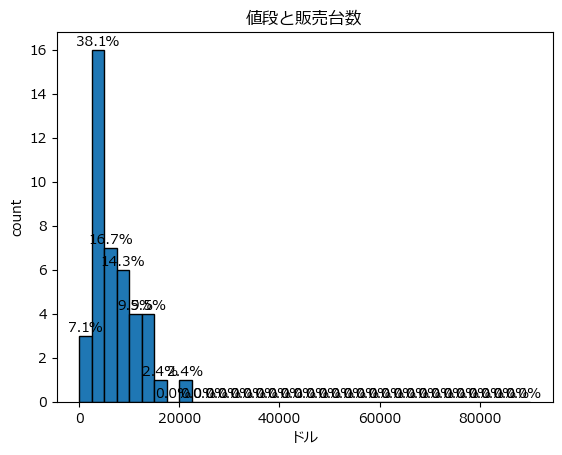

In [64]:
des('SATURN',train_df)

該当するメッセージ:
50%_10000
50%_12500
60%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000


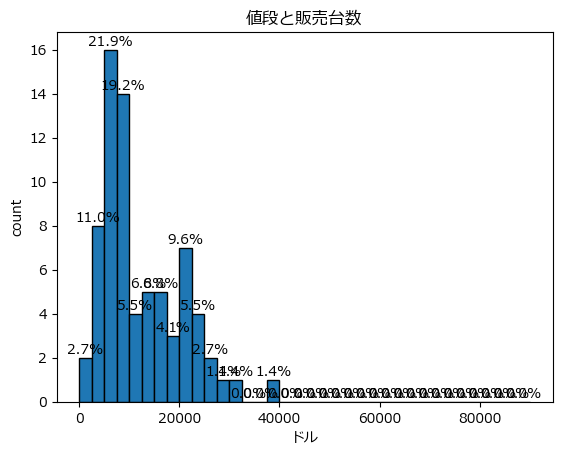

In [65]:
des('INFINITI',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


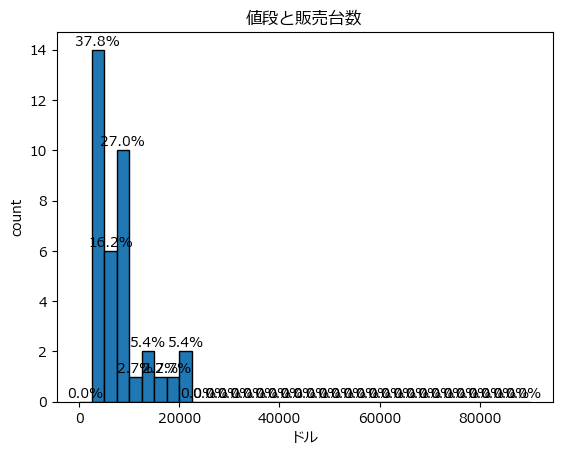

In [66]:
des('MINI',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


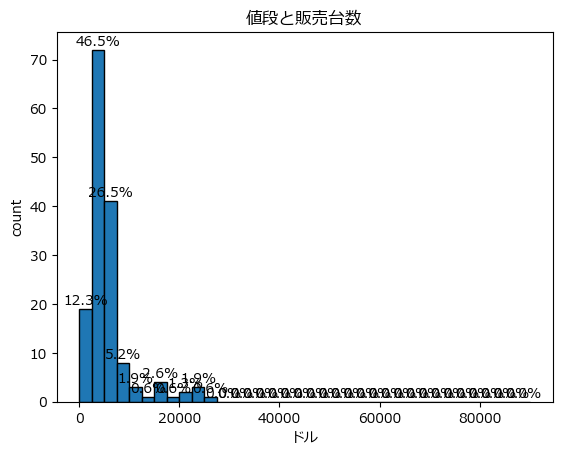

In [67]:
des('MERCURY',train_df)

該当するメッセージ:
50%_10000
50%_12500
20%_15000~25000
5%_25000~40000


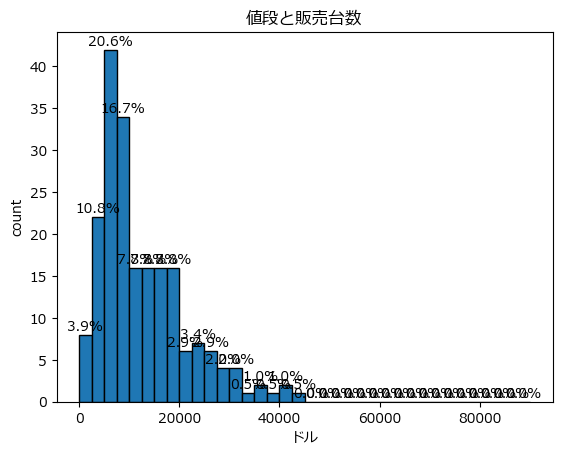

In [68]:
des('CADILLAC',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


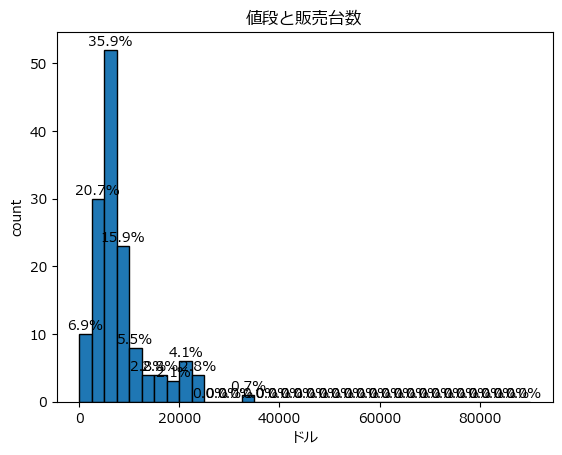

In [69]:
des('PONTIAC',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


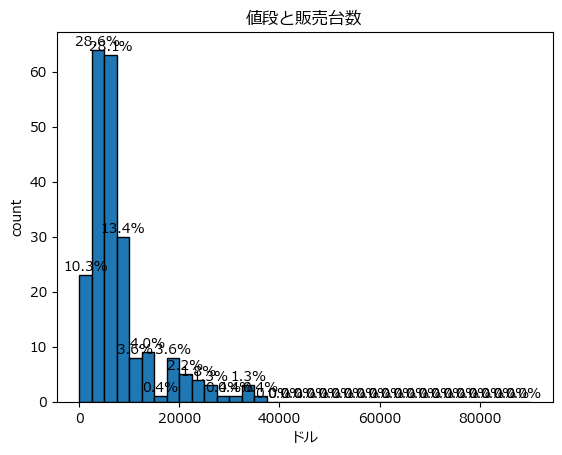

In [70]:
des('ACURA',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500


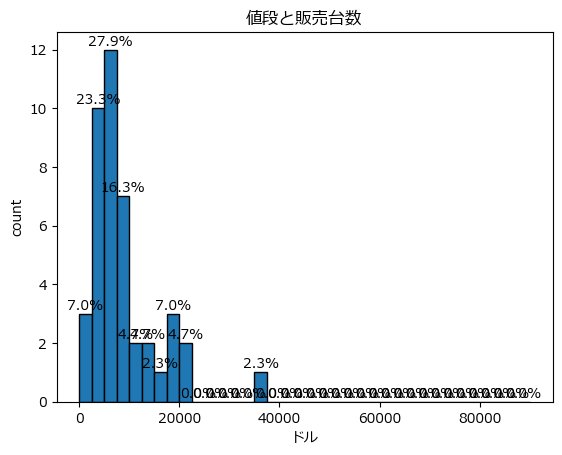

In [71]:
des('FIAT',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000


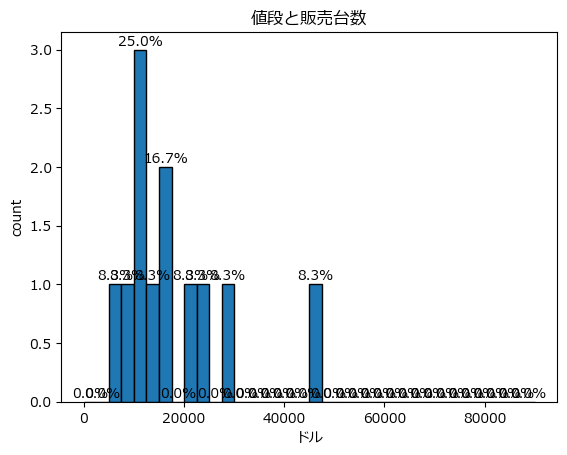

In [72]:
des('JAGUAR',train_df)

該当するメッセージ:
50%_10000
60%_10000
70%_10000
50%_12500
60%_12500
70%_12500
5%_25000~40000


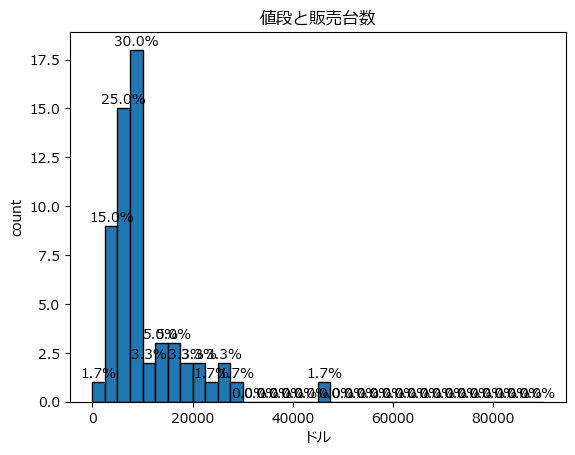

In [73]:
des('VOLVO',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000


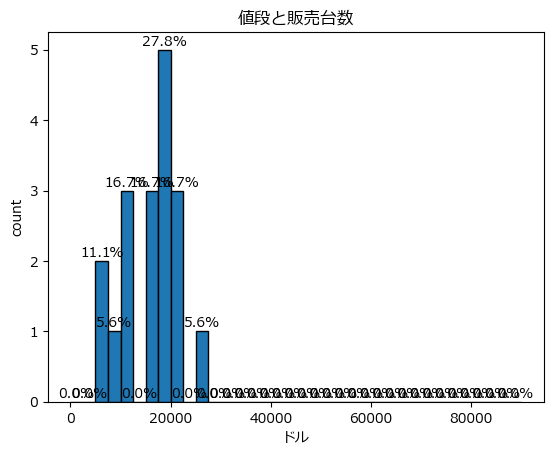

In [74]:
des('ROVER',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000
15%_25000~40000


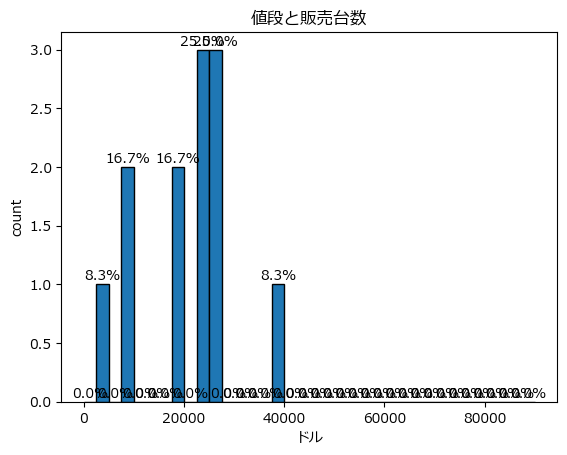

In [75]:
des('PORSCHE',train_df)

該当するメッセージ:
20%_15000~25000
25%_15000~25000
30%_15000~25000
5%_25000~40000
10%_25000~40000
15%_25000~40000


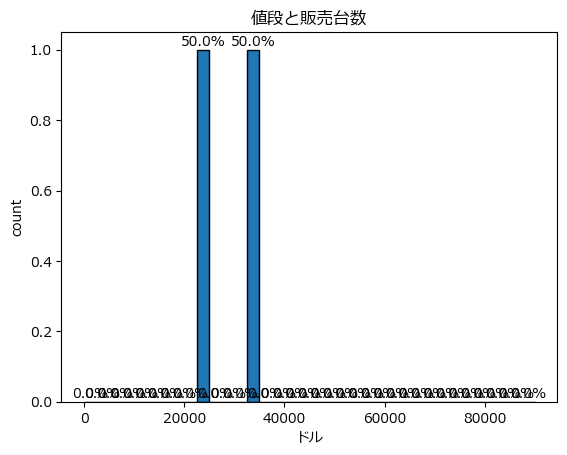

In [76]:
des('LAND ROVER',train_df)

該当するメッセージ:
50%_10000
50%_12500
20%_15000~25000
25%_15000~25000
30%_15000~25000


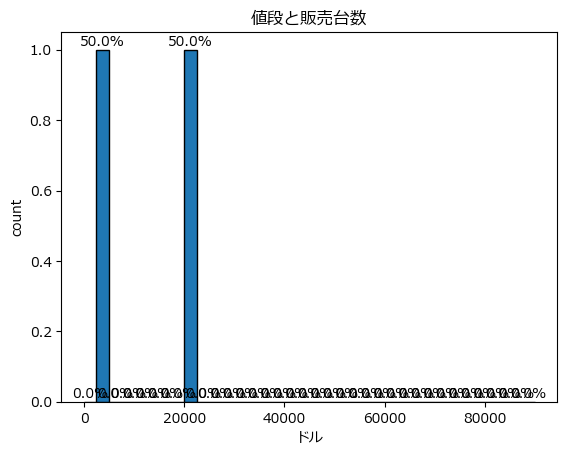

In [77]:
des('ASTON-MARTIN',train_df)

該当するメッセージ:
50%_10000
50%_12500
20%_15000~25000
25%_15000~25000
5%_25000~40000
10%_25000~40000
15%_25000~40000


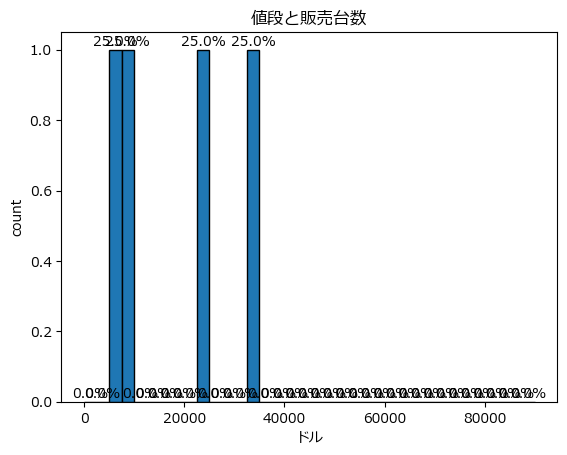

In [78]:
des('ALFA-ROMEO',train_df)

In [79]:
50_10000['TOYOTA','NISSAN', 'VOLKSWAGEN', 'LEXUS', 'BUICK',
    'SUBARU', 'DODGE','HONDA', 'HYUNDAI',
    'CHRYSLER','MAZDA', 'LINCOLN', 'KIA',
    'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
    'MERCURY', 'CADILLAC', 'PONTIAC', 'ACURA', 'FIAT', 
    'VOLVO','ASTON-MARTIN',
    'ALFA-ROMEO']
60_10000['TOYOTA','NISSAN', 'VOLKSWAGEN', 'LEXUS', 'BUICK',
    'HONDA','HYUNDAI',
    'CHRYSLER','MAZDA','LINCOLN', 'KIA',
    'SATURN', 'MINI',
    'MERCURY', 'PONTIAC', 'ACURA', 'FIAT',
    'VOLVO',]
70_10000['TOYOTA','VOLKSWAGEN', 
    'HONDA','HYUNDAI',
    'CHRYSLER','MAZDA',
    'SATURN', 'MINI',
    'MERCURY', 'PONTIAC', 'ACURA', 'FIAT',
    'VOLVO',]
50_12500['BMW', 'TOYOTA', 'FORD', 'NISSAN','BUICK', 'VOLKSWAGEN', 'LEXUS',
    'SUBARU','DODGE', 'CHEVROLET', 'JEEP', 'HONDA', 'HYUNDAI',
    'CHRYSLER','MAZDA', 'LINCOLN', 'KIA',
    , 'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
    'MERCURY', 'CADILLAC', 'PONTIAC', 'ACURA', 'FIAT',
    'VOLVO',
    'ALFA-ROMEO']
60_12500['TOYOTA','NISSAN', 'VOLKSWAGEN', 'LEXUS','BUICK',
    'HONDA', 'HYUNDAI',
    'CHRYSLER','MAZDA', 'LINCOLN', 'KIA',
    , 'MITSUBISHI', 'SATURN', 'INFINITI', 'MINI',
    'MERCURY', 'PONTIAC', 'ACURA', 'FIAT',
    'VOLVO',]
70_12500['TOYOTA','NISSAN', 'VOLKSWAGEN', 'LEXUS',
    'HONDA', 'HYUNDAI',
    'CHRYSLER','MAZDA', 'LINCOLN', 'KIA',
    , 'SATURN', 'MINI'
    'MERCURY', 'PONTIAC', 'ACURA', 'FIAT',
    'VOLVO']

SyntaxError: invalid syntax (2384351368.py, line 23)